### Goal
The goal of this project is to reduce costs associated with signup incentives by offering credit cards with carefully targeted benefits that will attract new cardholders.

The data includes cardholder data collected over the last 6 months. 

### Approach
Cluster the cardholders into different group and determine what benefits would be most attractive to each group.

By glancing over the column labels, I believe there are several key factors that need to be examined. Total puchases is definetly one of the most important features to cluster the cardholders. The other ones are "one-off" purchases vs. installments_purchases. I think those two are related with the benefits that would attract new cardholders. For users who make more one-off purchase, they might be more interested in card that offer a higher credit limit. On the other hand, for uses who use installments often, the card with low intro APR might be more attractive. Finally, cash advance is another type of behavior. I don't think a lot of credit cardholders use it. I will have a look of the data first.

#### Benefits strategy
1. Higher credit limit --- target customers who make more large purchases frequently.
2. Lower APR rate --- target customers who make INSTALLMENTS PURCHAES often.
3. Lower cash advance fee --- target customers who use CASH ADVANCE often. (Is this the behavior that credit card company try to avoid???)
4. NO benefits for the customers who don't pay off often.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [70]:
data = pd.read_csv("cc_info.csv")
data.head(n = 5)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


### EDA 
There are a few things I am interested to explore first. 
1. The purchase type - it seems that some customers prefer oneoff_purchases, some prefer installments_purchases. 
2. Most customers don't use the cash advance.
3. Payments and minimum_payments might indicate some behavior. I will explore it a litte bit too.
4. Check how many type of tenure. If there are enough data for 12 months, I would like to use only the data from those cardholders with 12 tenure to keep the consistency.
5. All the columns with frequency is still unclear to me. Need to explore and decide.

In [39]:
data.isna().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [71]:
print("The total data rows: ", len(data))
data = data.dropna()
print("The total data rows without nan: ", len(data))
print ("The unique custom rows: ", len(data.CUST_ID.unique()))

The total data rows:  8950
The total data rows without nan:  8636
The unique custom rows:  8636


In [72]:
data.TENURE.unique()

array([12,  8, 11,  9, 10,  6,  7])

In [73]:
data.groupby('TENURE')['TENURE'].count()

TENURE
6      184
7      177
8      183
9      164
10     226
11     356
12    7346
Name: TENURE, dtype: int64

In [82]:
data12 = data[data['TENURE']==12]

### Visualization - histogram
Exlore the distribution of the features I am interested.

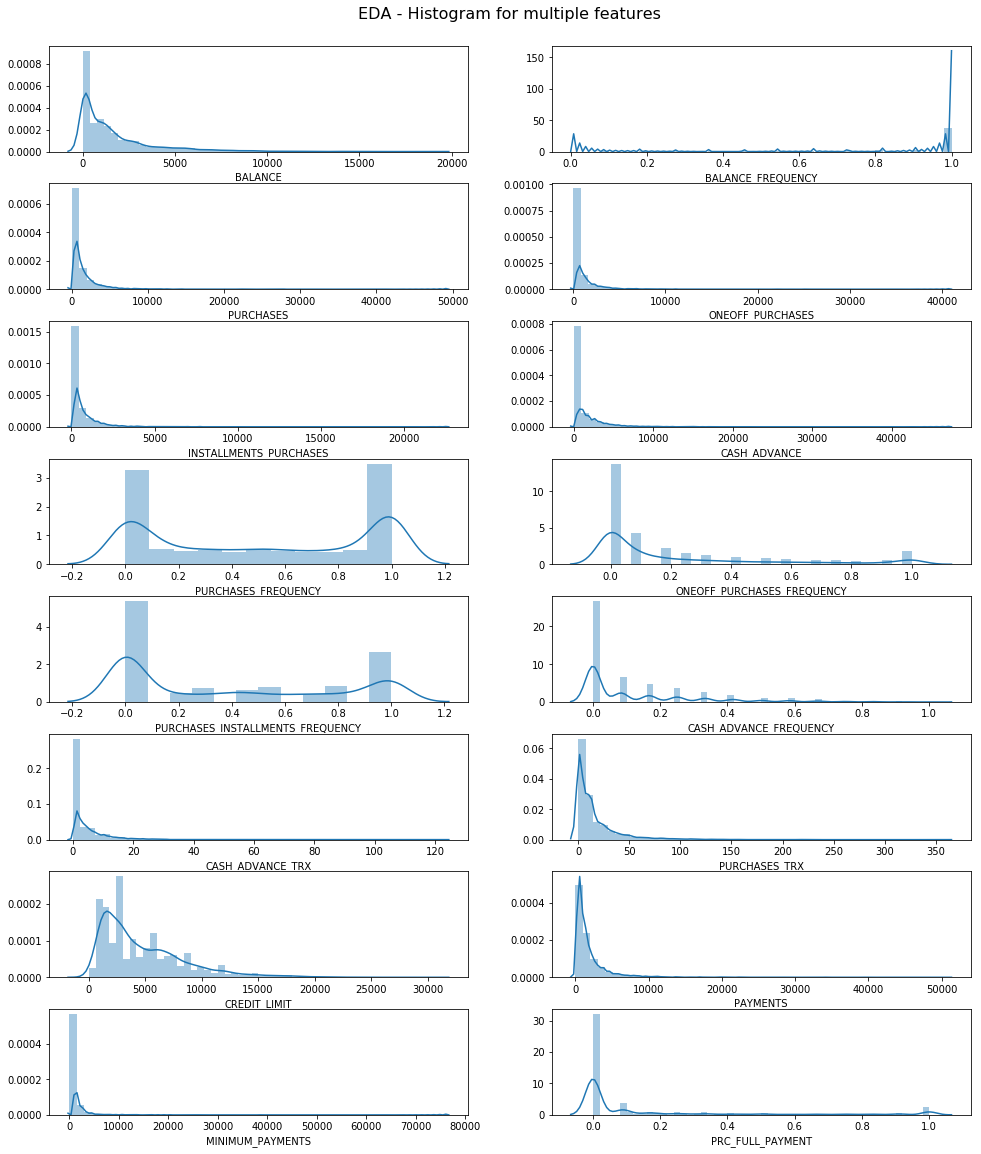

In [83]:
features = list(data.columns)
features.remove('CUST_ID')
# features.remove('CREDIT_LIMIT')
features.remove('TENURE')
lens = len(features)
row = int(math.ceil(lens/2.))
col = 2
fig, axes = plt.subplots(nrows = row, ncols = col, sharex = False, sharey = False, figsize = (16, 18))
axes_list = [item for sublist in axes for item in sublist]
for index, feature in enumerate(features): 
    ax = axes_list.pop(0)
    sns.distplot(data12[feature], ax = ax)
plt.suptitle('EDA - Histogram for multiple features', fontsize=16)
plt.subplots_adjust(left=0.1, wspace=0.2, hspace = 0.3, top=0.95)

All the features are screwed to the left. For the feature - PRC_FULL_PAYMENT, it is clustered at 0 and 1.

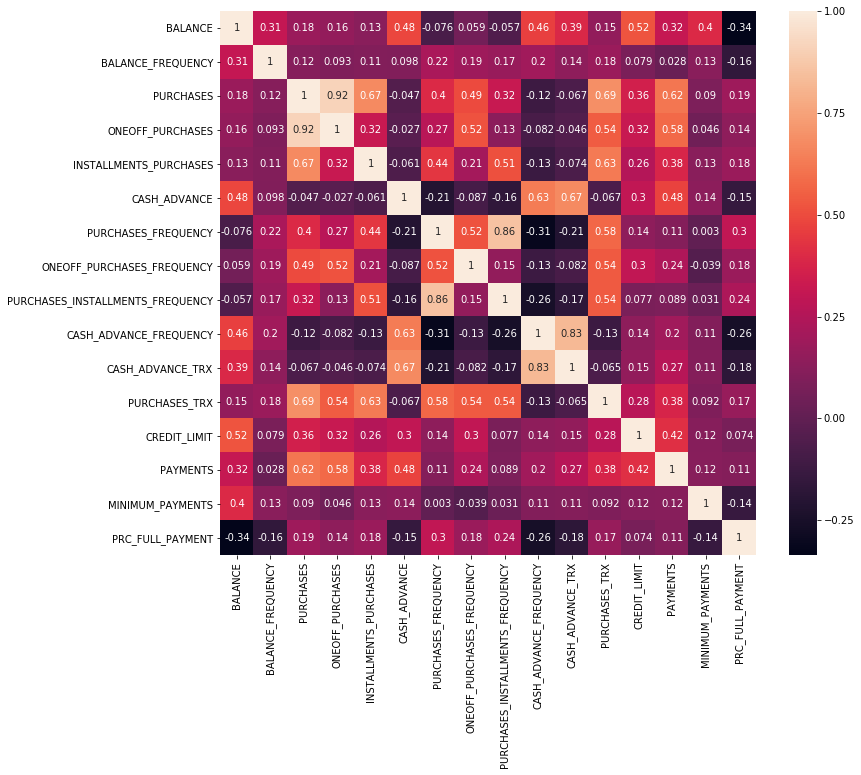

In [84]:
plt.figure(figsize = (12,10))
ax = sns.heatmap(data12[features].corr(),
                 xticklabels = features,
                 yticklabels = features,
                 annot = True)

In [85]:
log_features = ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS']
data_log = data12
data_log[log_features] += 1
data_log = data_log[log_features].apply(np.log)

/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


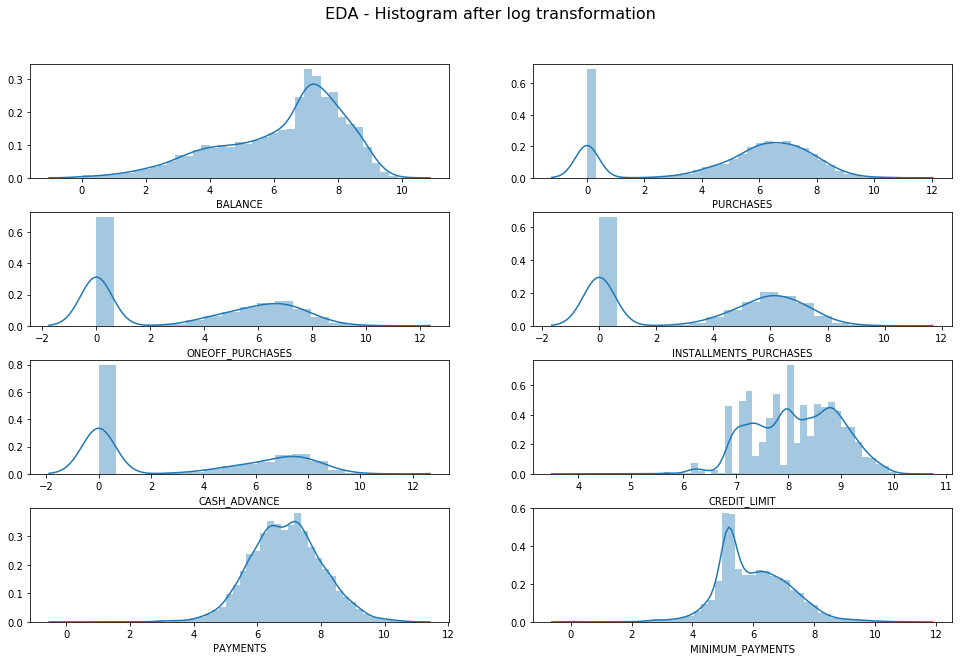

In [86]:
lens = len(log_features)
row = int(math.ceil(lens/2.))
col = 2
fig, axes = plt.subplots(nrows = row, ncols = col, sharex = False, sharey = False, figsize = (16, 10))
axes_list = [item for sublist in axes for item in sublist]
for index, feature in enumerate(log_features): 
    ax = axes_list.pop(0)
    sns.distplot(data_log[feature], ax = ax)
plt.suptitle('EDA - Histogram after log transformation', fontsize=16)
plt.subplots_adjust(left=0.1, wspace=0.2, hspace = 0.3, top=0.9)

/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


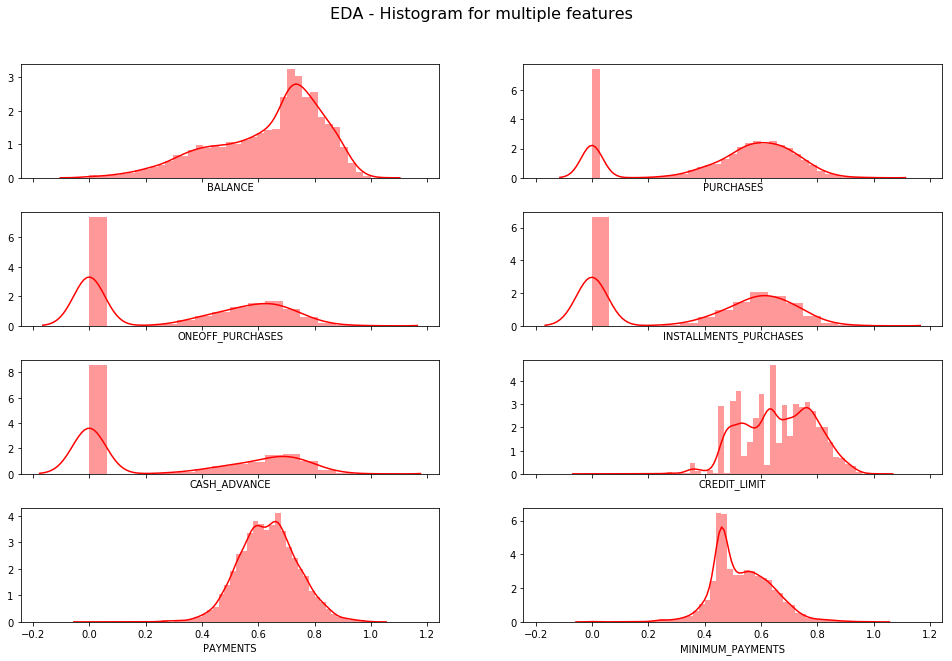

In [93]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = scaler.fit_transform(data_log)
df = pd.DataFrame(df, columns = log_features)
df.head()
fig, axes = plt.subplots(nrows = row, ncols = col, sharex = True, sharey = False, figsize = (16, 10))
axes_list = [item for sublist in axes for item in sublist]
for index, feature in enumerate(log_features): 
    ax = axes_list.pop(0)
    sns.distplot(df[feature], ax = ax, color = 'red')
plt.suptitle('EDA - Histogram for multiple features', fontsize=16)
plt.subplots_adjust(left=0.1, wspace=0.2, hspace = 0.3, top=0.9)

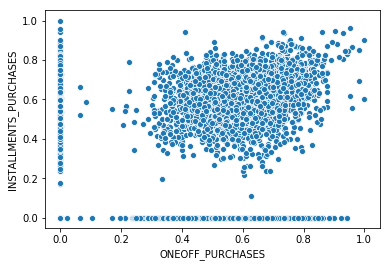

In [94]:
ax = sns.scatterplot(x="ONEOFF_PURCHASES", y="INSTALLMENTS_PURCHASES", data=df)

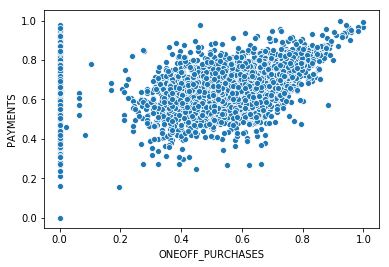

In [89]:
ax = sns.scatterplot(x="ONEOFF_PURCHASES", y="PAYMENTS", data=df)

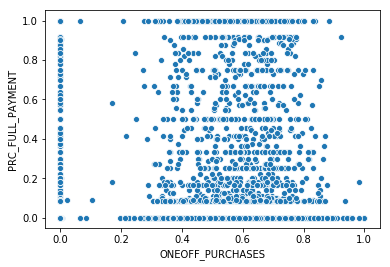

In [90]:
df['PRC_FULL_PAYMENT'] = data12['PRC_FULL_PAYMENT']
ax = sns.scatterplot(x="ONEOFF_PURCHASES", y='PRC_FULL_PAYMENT', data=df)

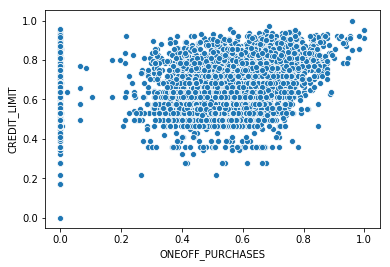

In [91]:
ax = sns.scatterplot(x="ONEOFF_PURCHASES", y='CREDIT_LIMIT', data=df)

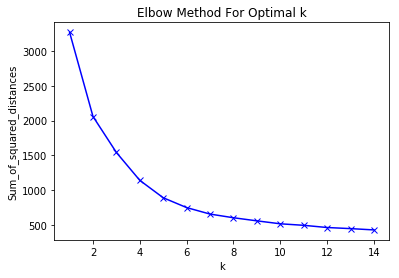

In [97]:
from sklearn.cluster import KMeans
X = np.array(df)
Sum_of_squared_distances = []
K = range(1, 15)

for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

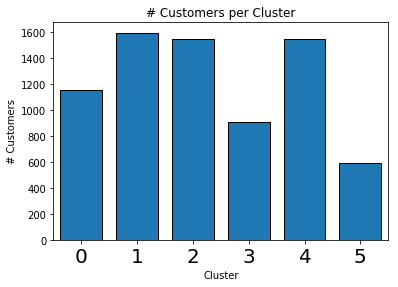

In [114]:
# Custumers per cluster
def bins_labels(bins, **kwargs):
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
    plt.xlim(bins[0], bins[-1])

    
n_clusters = 6

clustering = KMeans(n_clusters=n_clusters,
                    random_state=0
                   )

cluster_labels = clustering.fit_predict(X)

# plot cluster sizes
bins = range(n_clusters+1)
sns.distplot(cluster_labels, kde=False, bins= bins, hist_kws={"rwidth":0.75,'edgecolor':'black', 'alpha':1.0})
bins_labels(bins, fontsize=20)
plt.title('# Customers per Cluster')
plt.xlabel('Cluster')
plt.ylabel('# Customers')
plt.show()

# Assing cluster number to features and original dataframe
df['cluster_index'] = cluster_labels

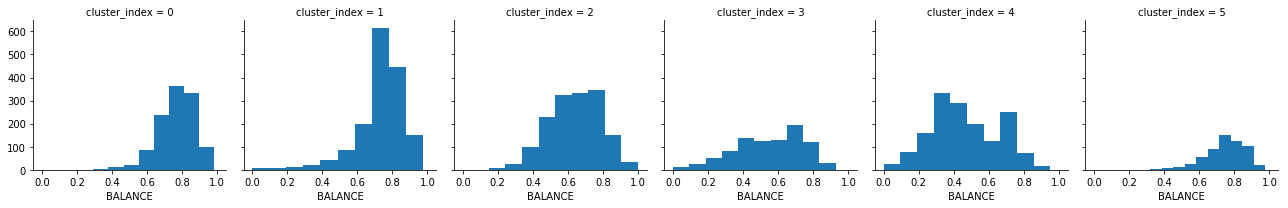

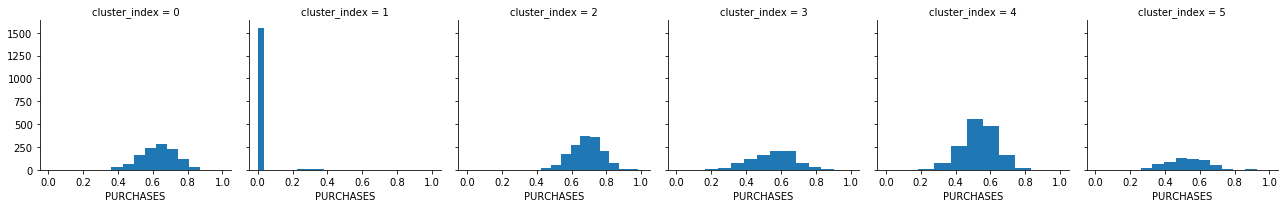

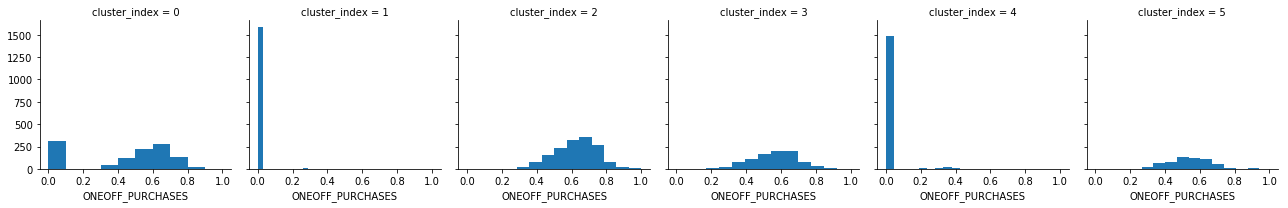

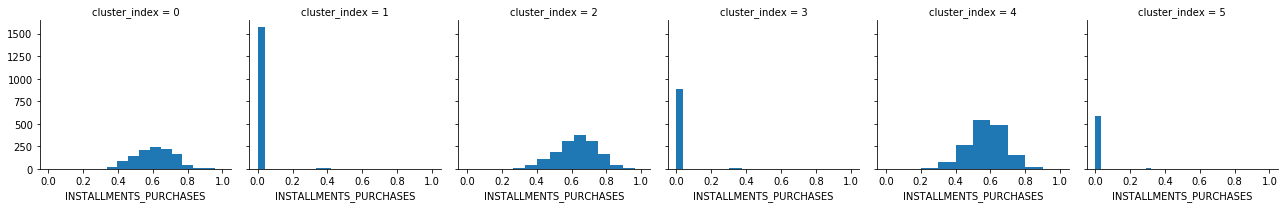

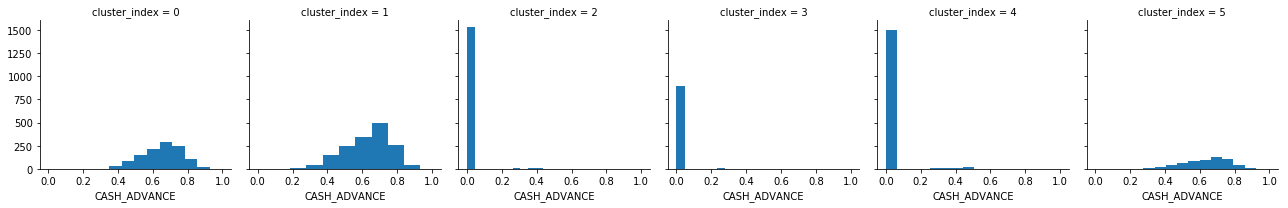

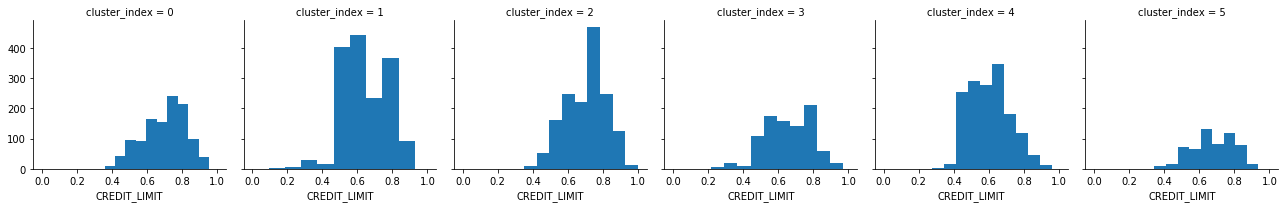

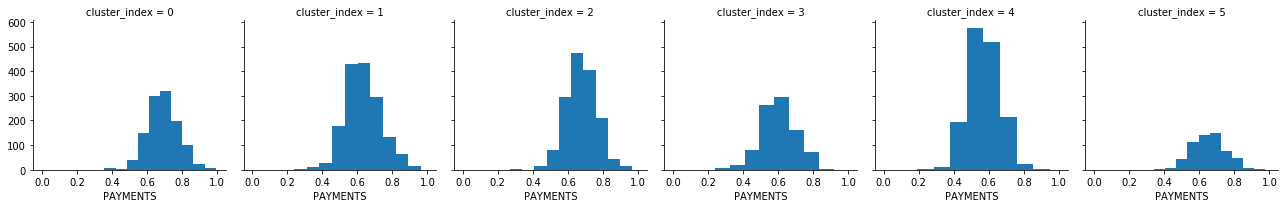

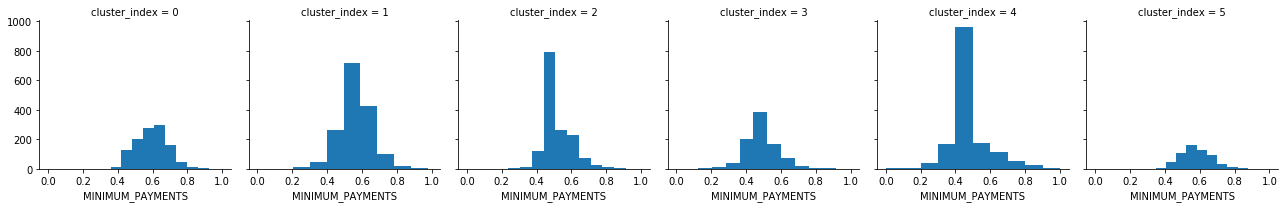

In [115]:
for c in df.drop('cluster_index', axis=1):
    grid= sns.FacetGrid(df, col='cluster_index', sharex = True, sharey = True)
    grid.map(plt.hist, c)

### Conclusion
1. Group 1 (index 0) use different purchases and the cash advance. The combined stategy with **higher credit limit, lower APR rate and lower cash advance fee** can be used.
2. Group 2 (index 1) have little purchases, but they use cash advance extensively. For those customers, **lower cash advance fee** would be attractive.
3. Group 3 (index 2) have higher purchase activities in both ONEOFF and INSTALLMENTS purchases, but they don't use cash advance. So **higher credit card limit and lower APR** would be a good strategy.
4. Group 4 (index 3) mainly use ONEOFF purchases, **higher credit card limit** should be used to target them.
5. Group 5 (index 4) mainly use INSTALLMENTS purchases, **a lower APR rate** can be used to target this group. 
6. Group 6 (index 5) have litte activity. They probably should be targeted at all.

### Problem
1. As a credit card company, they should not be targeting all the customers. I think the frequency data should be used to exclude some customers. But I am struggling to understand those frequency data.
2. Some features seem more important than others. I would consider to give the features different weight instead of treating them similarly in the future.

### An interesting visulization from Kaggle

In [116]:
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(X)

pca = PCA(2)
pca.fit(dist)
X_PCA = pca.transform(dist)
X_PCA.shape

(7346, 2)

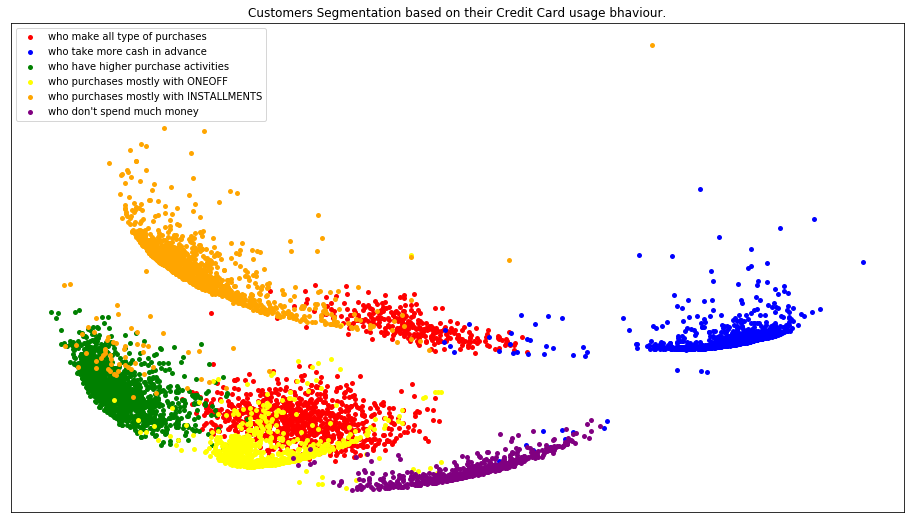

In [126]:
x, y = X_PCA[:, 0], X_PCA[:, 1]

colors = {0: 'red',
          1: 'blue',
          2: 'green', 
          3: 'yellow', 
          4: 'orange',
          5: 'purple'}

names = {0: 'who make all type of purchases', 
         1: 'who take more cash in advance',
         2: 'who have higher purchase activities', 
         3: 'who purchases mostly with ONEOFF', 
         4: 'who purchases mostly with INSTALLMENTS',
         5:'who don\'t spend much money'}

labels=clustering.labels_
df = pd.DataFrame({'x': x, 'y':y, 'label':labels}) 
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(16, 9)) 

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
            color=colors[name],label=names[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom= False,top=False,labelbottom=False)
    ax.tick_params(axis= 'y',which='both',left=False,top=False,labelleft=False)
    
ax.legend()
ax.set_title("Customers Segmentation based on their Credit Card usage bhaviour.")
plt.show()